# Exploratory Data Analysis

In the following, I analyze the dataset underlying the ML model for scheduling standby drivers.
<br>
I want to clarify which variables are interrelated, how they are distributed and thus find out which ones are suitable for the model as features.

#### Fragen?
* Are the data seasonal?
* What is the connection between how many standby drivers are needed?
* Frage 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Load and inspect the data:

In [2]:
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv') #, index_col=0)

In [3]:
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


* **date:** entry date
* **n_sick:** number of drivers called sick on duty
* **calls:** number of emergency calls
* **n_duty:** number of drivers on duty available
* **n_sby:** number of standby resources available
* **sby_need:** number of standbys, which are activated on a given day
* **dafted:** number of additional drivers needed due to not enough standbys

Let's look at numerical summaries:

In [4]:
df.describe(include = 'all')

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
unique,NaN,1152,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2017-07-23,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,575.500000,NaN,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,332.698061,NaN,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,0.000000,NaN,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,287.750000,NaN,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,575.500000,NaN,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,863.250000,NaN,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000


At least 4074 calls were received during the period, maximum 11.850. On average, 7919.53 calls were received.
<br>
On average, 34.7 drivers are needed on standby. However, since the maximum is 555, it is worth looking for outliers here.

Check for NaN-values:

In [5]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted


The following data types exist:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


So sehen die Were in verschiedenen Spalten aus:

In [7]:
df.n_duty.unique()

array([1700, 1800, 1900])

This means, there is only three options of drivers on duty. The values increase over time.

In [8]:
df.n_sby.unique()

array([90])

There are always 90 drivers on standby.

In [9]:
def min_max(data):
    print(data.min())
    print(data.max())

In [10]:
min_max(df.date)

2016-04-01
2019-05-27


The data covers a period of three years, from April 1st 2016 to May 27th 2019.

Correlation matrix between all the features we are examining and our y-variable:

In [11]:
corr = df.corr()

print(corr)

            Unnamed: 0    n_sick     calls    n_duty  n_sby  sby_need  \
Unnamed: 0    1.000000  0.495959  0.385679  0.927437    NaN  0.137543   
n_sick        0.495959  1.000000  0.155371  0.459501    NaN  0.022321   
calls         0.385679  0.155371  1.000000  0.364135    NaN  0.677468   
n_duty        0.927437  0.459501  0.364135  1.000000    NaN  0.090654   
n_sby              NaN       NaN       NaN       NaN    NaN       NaN   
sby_need      0.137543  0.022321  0.677468  0.090654    NaN  1.000000   
dafted        0.131938  0.016800  0.557340  0.084955    NaN  0.945168   

              dafted  
Unnamed: 0  0.131938  
n_sick      0.016800  
calls       0.557340  
n_duty      0.084955  
n_sby            NaN  
sby_need    0.945168  
dafted      1.000000  


### Investigate graphically

Make pairplots to investigate data further and spot correlations:

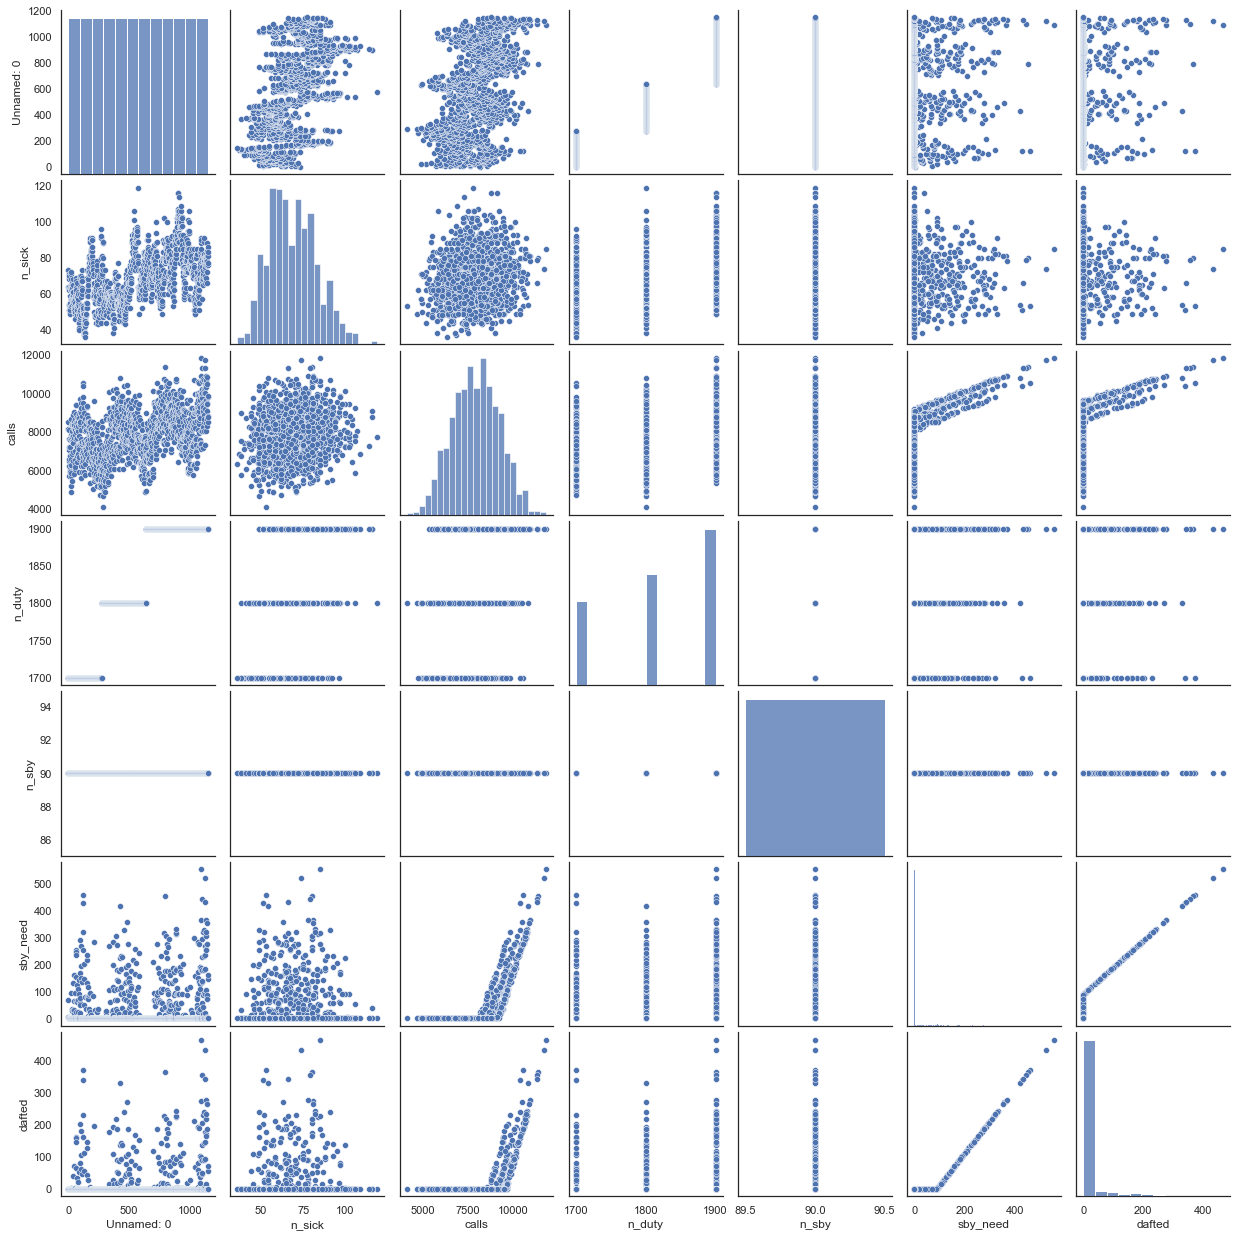

In [12]:
sns.set_theme(style="white")

sns.pairplot(df)

n_sick und calls sind saisonal, bei sby_need und calls sieht man, dass es erst ab 8000 calls Standby-Fahrer braucht.

The distribution of "sby_need" looks interesting, this is how the histogram looks in detail:

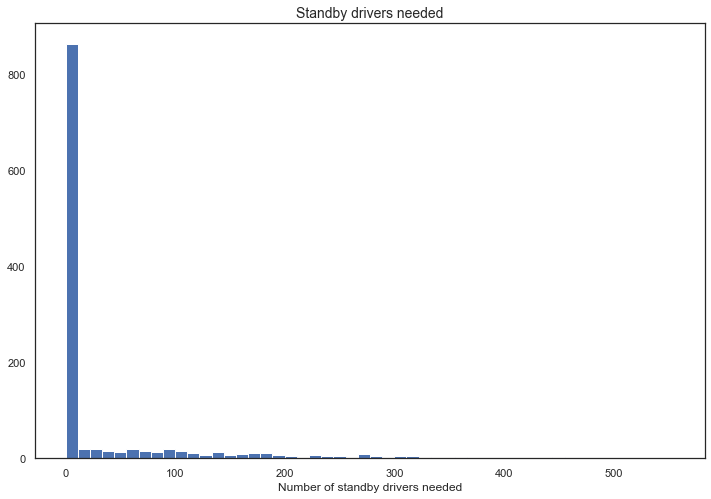

In [13]:
plt.figure(figsize=(12, 8))
plt.clf()
plt.hist(df.sby_need, bins=50)
plt.title('Standby drivers needed', fontsize=14)
plt.xlabel('Number of standby drivers needed')
plt.show()

In [14]:
new_df2 = df.groupby(['sby_need']).size()
print(new_df2)

sby_need
0.0      849
2.0        3
4.0        4
5.0        1
6.0        2
        ... 
445.0      1
454.0      1
461.0      1
523.0      1
555.0      1
Length: 185, dtype: int64


Standby drivers were not needed in nearly three-quarters of the cases. However, there are also individual cases in which several hundred were needed.
<br>
Another graphic will illustrate this.

<Figure size 432x288 with 0 Axes>

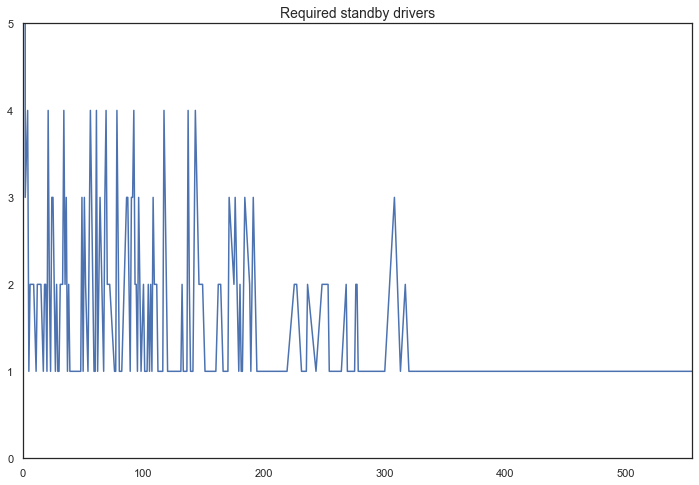

In [15]:
# needed???
plt.clf()
plt.figure(figsize=(12, 8))
plt.plot(new_df2)
plt.axis([0, 555, 0, 5])
plt.title('Required standby drivers', fontsize=14)
plt.show()

Most of the time no standby drivers were needed, otherwise between 2 and 5. It could become problematic that there are numerous individual cases where hundreds were needed.

Visualize data over the years:

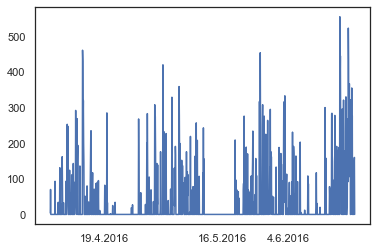

In [16]:
plt.plot(df.date, df.sby_need)
plt.xticks([204, 650, 900], ['19.4.2016', '16.5.2016', '4.6.2016'])
plt.show()

### Further Correlations

We observe that the number of drivers increases over the years. Is there a correlation with the number of calls?

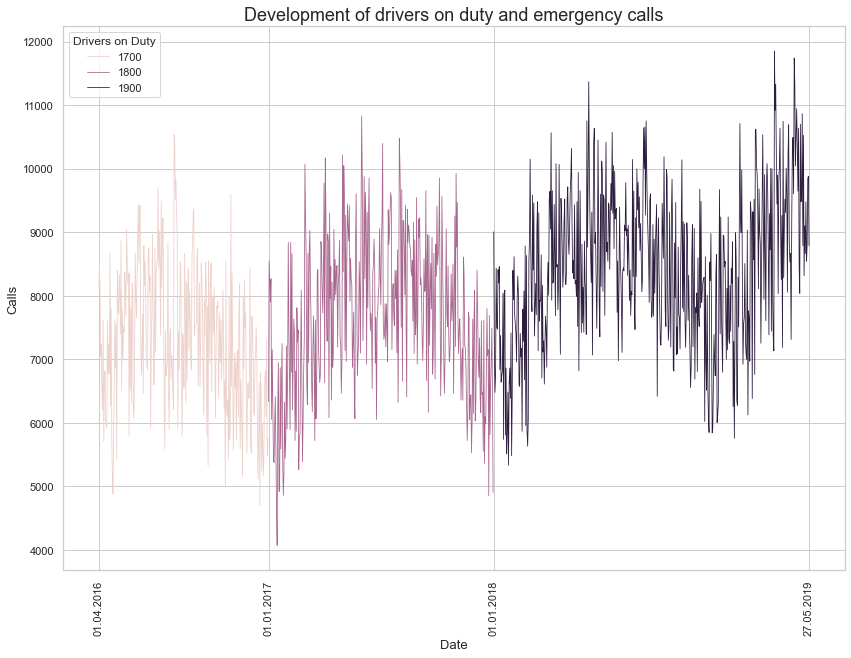

In [17]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.lineplot(x='date', y='calls', hue='n_duty', data=df, linewidth = 0.8)
plt.xticks([0, 275, 640, 1151], ['01.04.2016', '01.01.2017', '01.01.2018', '27.05.2019'])
plt.xticks(rotation=90)

plt.legend(labels=["1700","1800", "1900"], title = "Drivers on Duty")
plt.xlabel('Date', fontsize=13)
plt.ylabel('Calls', fontsize=13)
plt.title('Development of drivers on duty and emergency calls', fontsize=18)

plt.savefig("dev_n_duty_calls.svg")
plt.show()

The graph shows that the number of drivers on duty increases with the number of calls.

In [18]:
print(pearsonr(df.calls, df.n_duty)[0])

0.36413536110780714


According to Pearson's correlation coefficient r, the two variables are slightly positively correlated with a value of 0.36.

What about the number of calls and the number of drivers on sick leave?

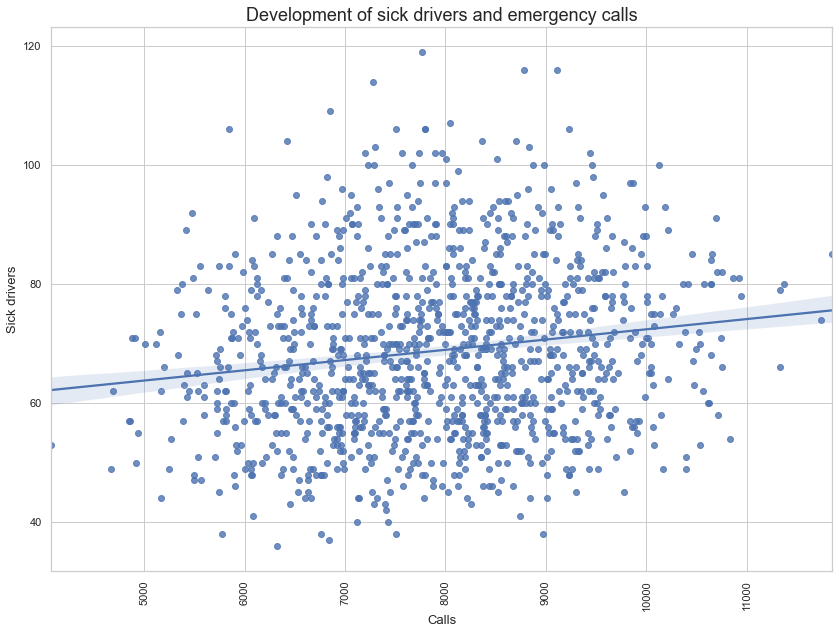

In [19]:
plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
sns.regplot(x='calls', y='n_sick', data=df)
plt.xticks(rotation=90)

plt.title('Development of sick drivers and emergency calls', fontsize=18)
plt.xlabel('Calls', fontsize=13)
plt.ylabel('Sick drivers', fontsize=13)

plt.show()

If the number of calls increases, the number of sick drivers slightly increases

In [20]:
print(pearsonr(df.calls, df.n_sick)[0])

0.15537086860280808


The variables are weakly positively correlated.

The pairplot above suggests a correlation between calls and drivers needed. Pearson's r confirms this:

In [21]:
print(pearsonr(df.calls, df.sby_need)[0])

0.677467517263761


The variables "n_sick" and "sby_need" are less related than thought:

In [22]:
print(pearsonr(df.n_sick, df.sby_need)[0])

0.022321406858650947


Check seasonality of the Standby drivers needed:

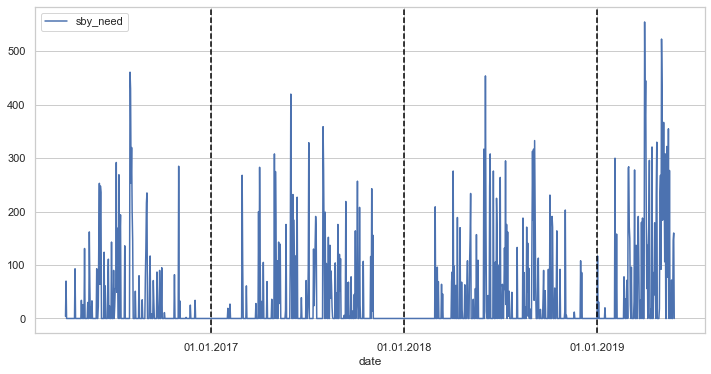

In [23]:
ax = df.plot(x='date', y='sby_need', figsize=(12,6))
plt.xticks([275, 640, 1005], ['01.01.2017', '01.01.2018', '01.01.2019'])
xcoords = [275, 640, 1005]
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

Check seasonality of the calls:

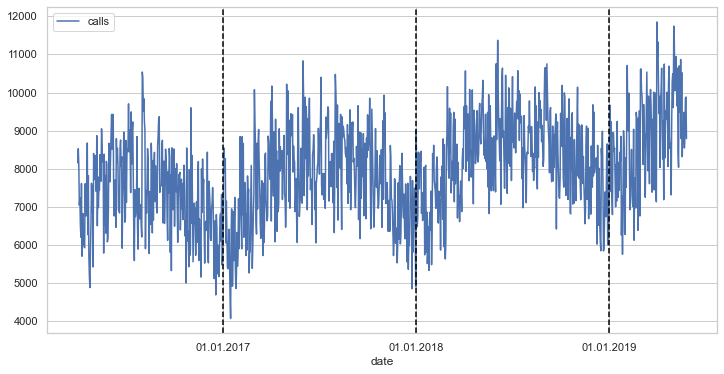

In [24]:
ax = df.plot(x='date', y='calls', figsize=(12,6))
plt.xticks([275, 640, 1005], ['01.01.2017', '01.01.2018', '01.01.2019'])
xcoords = [275, 640, 1005]
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

Seasonal decomposition:

In [25]:
# split variable into components to see seasonal variation

def decompose(data):
    res = sm.tsa.seasonal_decompose(data, period=365, model='additive')
    fig = res.plot()
    fig.set_size_inches(14,7)
    plt.show()

Decompose needed Standby drivers:

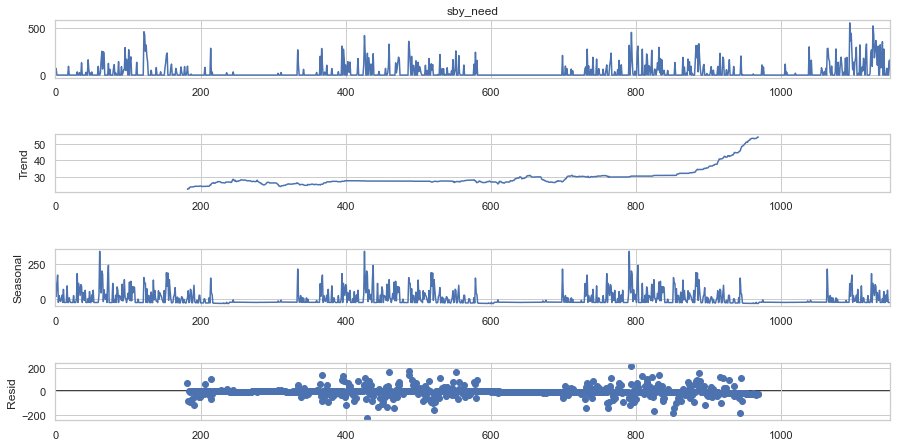

In [26]:
decompose(df.sby_need)

Decompose calls:

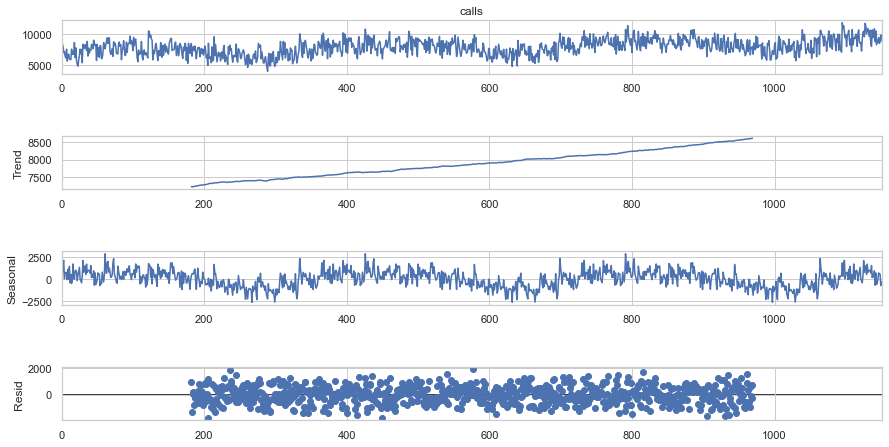

In [27]:
decompose(df.calls)

### check if data is stationary

Summary statistics:

In [28]:
def mean_var(data):
    X = data.values
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

check for standby drivers:

In [29]:
mean_var(df.sby_need)

mean1=29.512153, mean2=39.925347
variance1=4921.836658, variance2=7715.266996


check for calls:

In [30]:
mean_var(df.calls)

mean1=7563.270833, mean2=8275.791667
variance1=1442094.551649, variance2=1629701.164931


Mean and variance values for both are different and not in the same ball park.

Augmented Dickey-Fuller Test

In [31]:
def fuller_test(data):
	X = data.values
	result = adfuller(X)
	print('ADF Statistic: %f' % result[0])
	print('p-value: %f' % result[1])
	print('Critical Values:')
	for key, value in result[4].items():
		print('\t%s: %.3f' % (key, value))

check for standby need:

In [32]:
fuller_test(df.sby_need)

ADF Statistic: -6.248568
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Running the test prints the test statistic value of -6. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
<br>
As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -6 is less than the value of -3.436 at 1%.
<br>
This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
<br>
We can also look at the p-value, which is 0. This means we can easily reject the null and consider the distribution as stationary.
<br>
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
<br>
<br>
&rarr; the data is  stationary ([Tutorial](https://machinelearningmastery.com/time-series-data-stationary-python/)
)

check for calls:

In [33]:
fuller_test(df.calls)

ADF Statistic: -2.761936
p-value: 0.063920
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# stationary calls???

# calculate autocorrelation

with this [resource](https://www.alpharithms.com/autocorrelation-time-series-python-432909/)

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

In [76]:
# perform autocorrelation & visualization
def autocorr(data):
    res = sm.graphics.tsa.plot_acf(x=data, lags=100)
    res.set_size_inches(14,7)
    plt.show()

#The red shaded region is the confidence interval with a default value of α = 0.05. 
#Anything within this range represents a value that has no significant correlation with the most recent value.

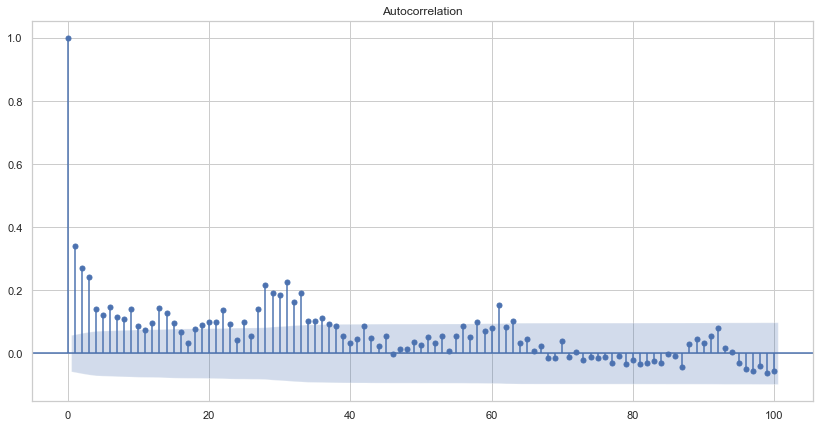

In [77]:
autocorr(df.sby_need)

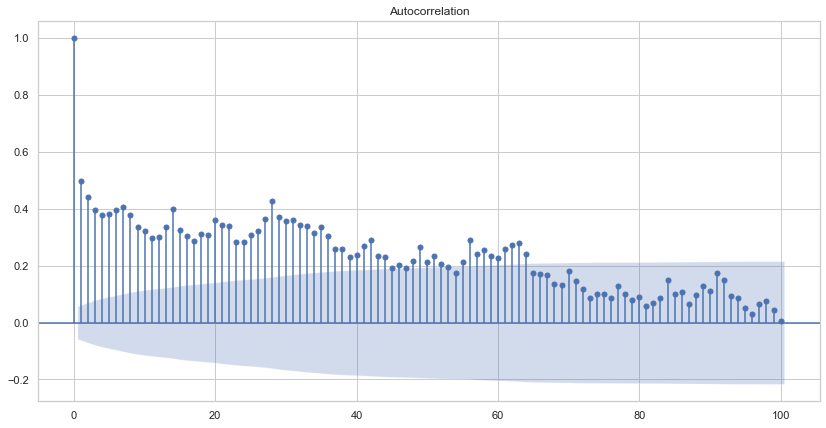

In [78]:
autocorr(df.calls)

In [91]:
# get lags over confidence intervall
from statsmodels.tsa.stattools import acf

def get_lags(data):
    a, ci = acf(x=data, nlags=100, alpha=0.05, fft=True)
    centered_ci = ci - a[:,None]
    outside = np.abs(a) >= centered_ci[:,1]
    inside = ~outside

    print(outside)


In [92]:
get_lags(df.sby_need)

[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True False False False  True  True  True  True  True
 False  True False  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False  True False
 False  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [93]:
get_lags(df.calls)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
